# Recitation 2
TA: Shiwei Tan (shiwei.tan@rutgers.edu)
## Outline
- Linear Data - Linear Model
- Quad Data - Linear Model
- Quad Data - Linear Model + Quad Features

# Generate Linear Dataset
We generate samples in 2-D space and they are from a normal distribution centered around the origin.

We then assign labels to them: samples above a straight line $x+y=0$ (with some random error) are positive samples. The others are negative samples.

In [1]:
import torch

In [5]:
def generate_data(n):
  xRaw = torch.randn((n, 2)) # Generating a scatterplot of 2D data points, centered in a 'normal' way around (0,0)
  x = torch.ones((n, 3))
  x[:,1] = xRaw[:,0]
  x[:,2] = xRaw[:,1]

  y = torch.zeros((n,1)) # For each of n rows, we will save a label that is either 0 or 1

  for i in range(n):
    noise = ( torch.randn( 1 ) * 0.1 ).item()

    # if x1 + x2 + (a little bit of noise) > 0, call that a 1, else, call it a 0
    # So the 'line of best division should be 1*x1 + 1*x2 = 0

    if 0 * x[i,0] + 1 * x[i,1] + 1 * x[i,2] + noise > 0:
      y[i,0] = 1
    else:
      y[i,0] = 0

  return x, y

Let's visualize our sample points.

In [3]:
import matplotlib.pyplot as plt

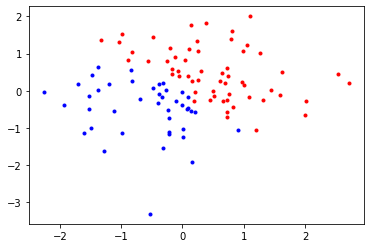

X.shape: torch.Size([100, 3])
Y.shape: torch.Size([100, 1])


In [6]:
n_data = 100
x, y = generate_data(n_data)

def visualize(x, y):
  pos_idx = (y[:, 0] == 1)
  neg_idx = (y[:, 0] == 0)
  plt.scatter(x[pos_idx, 1], x[pos_idx, 2], color='red', marker='.')
  plt.scatter(x[neg_idx, 1], x[neg_idx, 2], color='blue', marker='.')
  plt.show()

visualize(x, y)
print("X.shape:", x.shape)
print("Y.shape:", y.shape)

## Define Our Logistic Model
$$y=\frac{1}{1+e^{-w^Tx}}$$

In [7]:
def compute_logistic_model(x, w, n):
    y_prob = torch.zeros( (n,1) )

    for i in range(n):
        exponent = torch.sum( x[i,:] * w ) # These are element-wise operations

        y_prob[i,0] = 1/(1 + torch.exp(-1 * exponent) )
        # compute the probability, and save it

    return y_prob

The function to evaluate our model:

In [8]:
def test_accuracy(x,y,w,n):
    y_prob = compute_logistic_model(x,w,n) # for each x, compute the probablity that x should be labeled 1
    # note that the probability it should be labeled 0 is 1 - (that probablity)

    misclassifications = 0
    for i in range(n):
        if y_prob[i,0] >= 0.5 and y[i,0] == 0:# if probability is high but tag is 0, bad!
            misclassifications += 1
        elif y_prob[i,0] < 0.5 and y[i,0] == 1:# if probability is low but tag is 1, bad!
            misclassifications += 1

    return 1 - misclassifications / n # accuracy is 1 - (errors)

We randomly initialize the model weights and see its current accuracy:

In [9]:
w = torch.nn.Parameter( torch.randn((1,3)), requires_grad = True )
# Note data is 2D, so we need 3 parameters (to account for the bias term)
print("Initializing Logistic Weights:", w.data)
print("Initial Model Accuracy ( prob >= 0.5, guess y = 1, prob < 0.5, guess y = 0):", test_accuracy(x,y,w,n_data))

Initializing Logistic Weights: tensor([[1.0122, 0.6011, 0.7790]])
Initial Model Accuracy ( prob >= 0.5, guess y = 1, prob < 0.5, guess y = 0): 0.71


Now let's train our model.
$$
L(w)=-\sum_{i=1}^{N}y_i\log y_{pred} + (1-y_i)\log(1-y_{pred})
$$

In [10]:
from tqdm import tqdm
alpha = 0.05

loss_arr = []
acc_arr = []

for i in tqdm(range(1000)):
    y_prob = compute_logistic_model(x, w, n_data)
    # Compute the probabilities based on the mode

    loss_by_data_point = -1 * y * torch.log( y_prob ) - (1 - y) * torch.log( 1 - y_prob )
    # This will return a tensor of losses, one for each data point

    loss = torch.mean( loss_by_data_point )
    # The final loss is the average log loss over all data points

    loss.backward()

    with torch.no_grad():
        w -= alpha * w.grad

    w.grad = None

    loss_arr.append(loss.item())
    acc_arr.append(test_accuracy(x, y, w, n_data))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.11it/s]


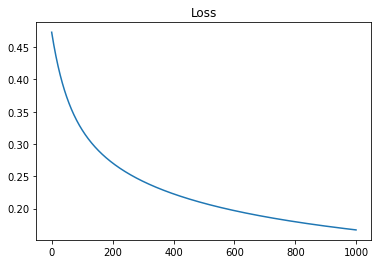

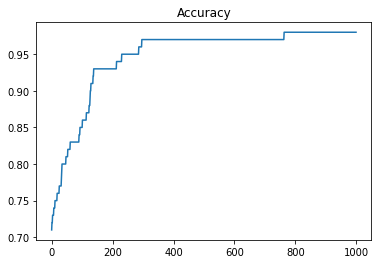

In [11]:
def vis_loss():
  plt.figure()
  plt.plot(loss_arr)
  plt.title("Loss")
  plt.show()

  plt.figure()
  plt.plot(acc_arr)
  plt.title("Accuracy")
  plt.show()

vis_loss()

## Generate a Quadratic Dataset
Now we have a circle with radius 1. Only the samples outside this circle are positive samples.

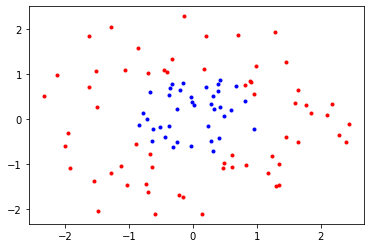

In [12]:
def generate_data(n):
    xRaw = torch.randn( (n,2) )
    x = torch.ones( (n,3) )
    x[:,[1,2]] = xRaw

    y = torch.zeros( (n,1) )
    for i in range(n):
        noise = ( torch.randn( 1 ) * 0.1 ).item()

        if (x[i,1])**2 + (x[i,2])**2 + noise > 1:
            y[i,0] = 1
        else:
            y[i,0] = 0

    return x,y

n_data = 100
x, y = generate_data(n_data)
visualize(x, y)

Randomly initialize and evaluate:

In [13]:
w = torch.nn.Parameter( torch.randn((1,3)), requires_grad = True )
print("Initializing Logistic Weights:", w.data)
print("Initial Model Accuracy ( prob >= 0.5, guess y = 1, prob < 0.5, guess y = 0):", test_accuracy(x,y,w,n_data))

Initializing Logistic Weights: tensor([[-0.8834,  1.7211,  0.5131]])
Initial Model Accuracy ( prob >= 0.5, guess y = 1, prob < 0.5, guess y = 0): 0.5800000000000001


Let's train it!

In [14]:
alpha = 0.05

loss_arr = []
acc_arr = []

for i in tqdm(range(500)):
    y_prob = compute_logistic_model(x, w, n_data)

    loss_by_data_point = -1 * y * torch.log( y_prob ) - (1 - y) * torch.log( 1 - y_prob )
    loss = torch.mean( loss_by_data_point )

    loss.backward()

    with torch.no_grad():
        w -= alpha * w.grad
    w.grad = None

    loss_arr.append(loss.item())
    acc_arr.append(test_accuracy(x,y,w,n_data))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.89it/s]


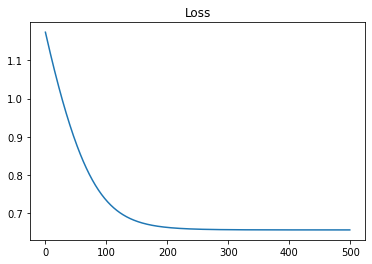

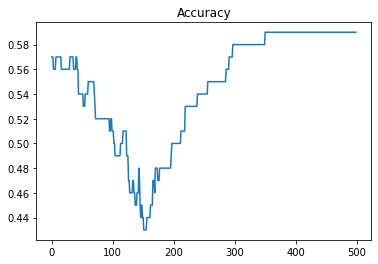

In [15]:
vis_loss()

## Add Quadratic Features to the Data
Every sample point $(1, x_1, x_2)$ is mapped to $(1, x_1, x_2, x_1^2, x_2^2, x_1\cdot x_2)$.

Now, a linear model on the new data can capture the true model of $x_1^2+x_2^2>1$.

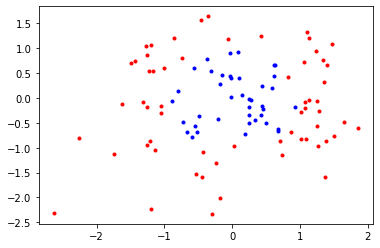

In [17]:
def generate_data(n):
    xRaw = torch.randn( (n,2) )
    y = torch.zeros( (n,1) )
    for i in range(n):
        noise = ( torch.randn( 1 ) * 0.1 ).item()

        if (xRaw[i,0])**2 + (xRaw[i,1])**2 + noise > 1:
            y[i,0] = 1
        else:
            y[i,0] = 0

    x = torch.ones( (n,6) )
    x[:,[1,2]] = xRaw
    x[:,3] = xRaw[:,0] ** 2
    x[:,4] = xRaw[:,1] ** 2
    x[:,5] = xRaw[:,0] * xRaw[:,1]

    return x,y

n_data = 100
x, y = generate_data(n_data)
visualize(x[:, :3], y)

Now we initialize our model.

In [18]:
w = torch.nn.Parameter( torch.randn((1,6)), requires_grad = True ) # Note we have 6 total features now, need 6 weights
print("Initializing Logistic Weights:", w.data)
print("Initial Model Accuracy ( prob >= 0.5, guess y = 1, prob < 0.5, guess y = 0):", test_accuracy(x,y,w,n_data))

Initializing Logistic Weights: tensor([[ 1.5554, -0.3777, -0.4164, -0.5238,  0.1045,  1.3852]])
Initial Model Accuracy ( prob >= 0.5, guess y = 1, prob < 0.5, guess y = 0): 0.43999999999999995


Train:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.30it/s]


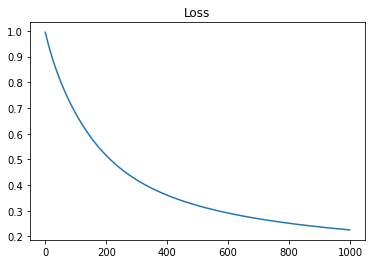

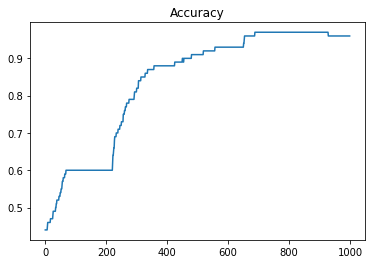

In [19]:
alpha = 0.05

loss_arr = []
acc_arr = []

for i in tqdm(range(1000)):
    y_prob = compute_logistic_model(x, w, n_data)

    loss_by_data_point = -1 * y * torch.log( y_prob + 0.0001 ) - (1 - y) * torch.log( 1 - y_prob + 0.0001 )
    # The 0.0001 above is for numerical stability. We don't want to calculate log(0).

    loss = torch.mean( loss_by_data_point )

    loss.backward()

    with torch.no_grad():
        w -= alpha * w.grad
    w.grad = None

    loss_arr.append(loss.item())
    acc_arr.append(test_accuracy(x,y,w,n_data))

vis_loss()